<a href="https://colab.research.google.com/github/lsiecker/Deep-Learning/blob/main/assignment_2/Assignment_2_2AMM10_22_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Details

## Group Name: group21

### Student 1: N.P.G.T. van Beuningen	1353624

### Student 2: D.P.M. van der Hoorn	1873334

### Student 3: L.R. Siecker	1344838

# Loading Data and Preliminaries

In [ ]:
from google.colab import drive
import io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
import requests
import pickle
import scipy.stats
import sklearn.metrics as sm
import time
from tqdm.notebook import tqdm, trange

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.cuda.memory import list_gpu_processes
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
base_url = "https://github.com/lsiecker/Deep-Learning/raw/main/assignment_2/data/"

In [ ]:
def load_data(url, task):
    """
    Loads a numpy array from surfdrive.

    Input:
    url: Download link of dataset

    Outputs:
    dataset: numpy array with input features or labels
    """

    response = requests.get(url)
    response.raise_for_status()

    array = load_array(io.BytesIO(response.content), task)

    return array

In [ ]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [ ]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_data(f"{base_url}task%201/train/trajectory_0.npz?raw=true", task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [ ]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time.
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_data(f'{base_url}task%202_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_data(f'{base_url}task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


# Helper Functions Setup

In [ ]:
drive.mount('/content/drive')
destination_file = '/content/drive/MyDrive/'

def save_dataset(dataset, filename):
  "Saves dataset into file on Google Drive"
  filename = destination_file + filename
  with open(filename, 'wb') as file:
     pickle.dump(dataset, file)
  print(f"Dataset saved to {filename}.")

def load_dataset(filename):
  "Loades dataset from file on Google Drive"
  filename = destination_file + filename
  with open(filename, 'rb') as file:
      dataset = pickle.load(file)
  return dataset

Mounted at /content/drive


### Plotting Functions

In [ ]:
class PlotTraining():
    def __init__(self):
      self.train_loss = []
      self.evaluation_loss = []
      self.test_loss = []

    def add_train(self, loss):
      self.train_loss.append(loss)

    def add_evaluation(self, loss):
      self.evaluation_loss.append(loss)

    def add_test(self, loss):
      self.test_loss.append(loss)

    def plot(self):
      fig, ax1 = plt.subplots()
      ax1.set_xlabel('epochs')
      ax1.tick_params(axis='x')
      ax2 = ax1.twinx()
      if self.train_loss is not [None] * len(self.train_loss) \
          or self.evaluation_loss is not [None] * len(self.evaluation_loss) \
          or self.test_loss is not [None] * len(self.test_loss):
        ax2.set_ylabel('loss')

      color = ["tab:blue", "tab:orange", "tab:purple", "tab:red", "tab:green", "tab:pink"]

      if self.train_loss:
        ax2.plot(list(range(len(self.train_loss))), self.train_loss, label = "Training Loss", color=color[1])
      if self.evaluation_loss:
        ax2.plot(list(range(len(self.evaluation_loss))), self.evaluation_loss, label = "Validation Loss", color=color[3])
      if self.test_loss:
        ax2.plot(list(range(len(self.test_loss))), self.test_loss, label = "Test Loss", color=color[5])

      fig.legend()
      fig.tight_layout()
      plt.locator_params(axis='x', integer=True, tight=True)
      plt.show()

In [414]:
# Assuming you have the train and test datasets loaded as numpy arrays
def plot_prediction(y_pred, y_test, object_index, uncertainty):
    if uncertainty:
        predicted = y_pred #
        predicted_x = predicted[object_index, :, 0, 1]
        predicted_y = predicted[object_index, :, 1, 1]

        # Extract the uncertainty values for x and y
        uncertainty_x = predicted[object_index, :, 0, 3]
        uncertainty_y = predicted[object_index, :, 1, 3]

    else:
        predicted = y_pred.view(y_pred.shape[0], 49, 4).narrow(dim=-1, start=0, length=2).cpu().detach().numpy()
        predicted_x = predicted[object_index, :, 0]
        predicted_y = predicted[object_index, :, 1]
    y_test = y_test.view(y_test.shape[0], 49, 2)
    true_x = y_test[object_index, :, 0]
    true_y = y_test[object_index, :, 1]

    # Filter the values where both x and y are zero
    mask = np.logical_or(predicted_x != 0, predicted_y != 0)
    predicted_x = predicted_x[mask]
    predicted_y = predicted_y[mask]

    mask = np.logical_or(true_x != 0, true_y != 0)
    true_x = true_x[mask]
    true_y = true_y[mask]

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the x and y trajectories for the train dataset
    axs[0].plot(predicted_x.flatten(), predicted_y.flatten(), label='Predicted')

    if uncertainty:
        axs[0].fill_between(
            predicted_x.flatten(),
            predicted_y.flatten() - uncertainty_y.flatten(),
            predicted_y.flatten() + uncertainty_y.flatten(),
            alpha=0.5,
            label='Uncertainty (y)'
        )
        axs[0].fill_betweenx(
            predicted_y.flatten(),
            predicted_x.flatten() - uncertainty_x.flatten(),
            predicted_x.flatten() + uncertainty_x.flatten(),
            alpha=0.5,
            label='Uncertainty (x)'
        )

    axs[0].set_xlabel('X-coordinate')
    axs[0].set_ylabel('Y-coordinate')
    axs[0].set_title(f'Trajectories of Object {object_index} (Predicted)')
    axs[0].legend()

    # Plot the x and y trajectories for the test dataset
    axs[1].plot(true_x.flatten(), true_y.flatten(), label='Validation')
    axs[1].set_xlabel('X-coordinate')
    axs[1].set_ylabel('Y-coordinate')
    axs[1].set_title(f'Trajectories of Object {object_index} (Validation)')
    axs[1].legend()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

In [416]:
def uncertainty_distribution(predictions):
    mean_predictions = np.mean(predictions, axis=0)

    # Calculate the variance across the runs
    variance = np.var(predictions, axis=0)

    # Calculate the standard deviation across the runs
    standard_deviation = np.std(predictions, axis=0)

    # Sample prediction from distribution
    uncertainty_distribution = np.random.normal(loc=mean_predictions, scale=np.sqrt(variance))

    # Calculate the 95% confidence intervals
    CI_lower = mean_predictions - 1.96 * standard_deviation
    CI_upper = mean_predictions + 1.96 * standard_deviation

    # Stack values so that all information regarding the distribution is available in output
    distribution_array = np.stack((uncertainty_distribution, mean_predictions, variance, standard_deviation, CI_lower, CI_upper), axis=-1)
    reshaped_dist_array = np.reshape(distribution_array, (predictions.shape[1], 49, 2, 6))

    return uncertainty_distribution, reshaped_dist_array

In [226]:
def sequence_rotation(source_sequence):
    x = source_sequence[:, 1]
    y = source_sequence[:, 2]
    v_x = source_sequence[:, 3]
    v_y = source_sequence[:, 4]

    # Create four rotated copies of the batch of sequences
    rotated_sequences = [
        torch.stack([source_sequence[:, 0], x, y, v_x, v_y], dim=1),  # 0 degrees rotation
        torch.stack([source_sequence[:, 0], y, -x, -v_y, v_x], dim=1),  # 90 degrees rotation
        torch.stack([source_sequence[:, 0], -x, -y, -v_x, -v_y], dim=1),  # 180 degrees rotation
        torch.stack([source_sequence[:, 0], -y, x, v_y, -v_x], dim=1),  # 270 degrees rotation
    ]

    rotated_sequences_tensor = torch.stack(rotated_sequences, dim=1)  # Shape: [batch_size, 4, sequence_length, 5]

    return rotated_sequences_tensor.view(rotated_sequences_tensor.shape[0] * rotated_sequences_tensor.shape[1], 5)

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    # arrays are stored as tuples; get respective lists
    source_points = [x[0] for x in batch]
    target_points = [x[1] for x in batch]

    source_sequences = [sequence_rotation(sequence) for sequence in source_points]

    # pad sequences in batch
    source_padded = pad_sequence(sequences = source_sequences,
                             batch_first = True)
    target_padded = pad_sequence(sequences = target_points,
                             batch_first = True)

    batch_mask = torch.all(source_padded != 0, dim=-1)
    return source_padded.to(device), target_padded.to(device), batch_mask[:, ::4]

In [249]:
def train(dataloader, log_interval, task23):

  model.train()

  start_time = time.time()
  for idx, (trajectory_points, target_points, batch_mask) in enumerate(tqdm(dataloader)):
        trajectory_points = trajectory_points.to(device)
        target_positions = target_points.to(device).narrow(dim=-1, start=0, length=2)

        model.optimizer.zero_grad()
        y_pred = model(trajectory_points)

        if task23:
          reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2)
          loss = model.criterion(reshaped_y_pred[batch_mask], target_positions[batch_mask])
        else:
          loss = model.criterion(y_pred[batch_mask], target_positions[batch_mask])

        loss.backward()
        model.optimizer.step()

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| loss {:8.3f}'.format(epoch, idx, len(dataloader),
                                              loss))
            start_time = time.time()

  return loss

def evaluate(dataloader, task23):
    model.eval()

    with torch.no_grad():
        for idx, (trajectory_points, target_points, batch_mask) in enumerate(tqdm(dataloader)):

            trajectory_points = trajectory_points.to(device)
            target_points = target_points.to(device).narrow(dim=-1, start=0, length=2)

            y_pred = model(trajectory_points)
            if task23:
              reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2)
              loss = model.criterion(reshaped_y_pred[batch_mask], target_points[batch_mask])
            else:
              loss = model.criterion(y_pred[batch_mask], target_points[batch_mask])

    return loss

# Model Setup

In [ ]:
class Encoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        self.dropout = nn.Dropout(dropout)

        self.double()


    def forward(self, src):
        """
        Forward pass of encoder model. It aims at
        transforming the input sentence to a dense vector
        """

        output, _ = self.rnn(src)

        output = self.dropout(output)

        return output

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_size, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(hid_dim, hid_dim, n_layers, dropout = dropout)

        self.fc_out = nn.Linear(hid_dim, output_size)

        self.dropout = nn.Dropout(dropout)

        self.double()


    def forward(self, input):
        """
        Forward pass of the decoder model. It aims at transforming
        the dense representation of the encoder into a sequence that is
        used for position prediction
        """

        output, _ = self.rnn(input)

        prediction = self.fc_out(output)

        # Only select points that were in original dataset
        reduced_output = prediction[:, ::4, :]

        return reduced_output

In [ ]:
class TrainPointPredictor(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        self.criterion = nn.MSELoss()

        self.double()


    def forward(self, source_points):
        """
        Forward pass of the seq2seq model. It encodes the source sentence into
        a dense representation and thereafter transduces into the target
        sentence.

        Inputs:
        src: padded index representation of source sentences with shape [src len, batch size]
        trg:  padded index representation of target sentences with shape [trg len, batch size]

        Outputs:
        output:
        """

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        input = self.encoder(source_points)
        output = self.decoder(input)

        return output

# Task **1**

## Data Handling and Preprocessing

In [362]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%201/train/trajectory_{i}.npz?raw=true", task='task 1'))
  save_dataset(train_data, "train_data")

In [363]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%201/test/trajectory_{i}.npz?raw=true", task='task 1'))
  save_dataset(test_data, "test_data")

In [364]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_batch)

## Model Training

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time:  1.11s | train loss   21.299 validation loss   23.110 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time:  1.00s | train loss   13.306 validation loss   13.439 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time:  1.04s | train loss    8.248 validation loss    9.464 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time:  0.98s | train loss    7.372 validation loss    8.881 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time:  0.89s | train loss    6.993 validation loss    8.304 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time:  0.80s | train loss    6.721 validation loss    8.050 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time:  0.84s | train loss    6.566 validation loss    7.876 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time:  0.82s | train loss    6.444 validation loss    7.717 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time:  0.83s | train loss    6.339 validation loss    7.566 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  10 | time:  0.83s | train loss    6.252 validation loss    7.420 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  11 | time:  0.85s | train loss    6.180 validation loss    7.286 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  12 | time:  0.84s | train loss    6.122 validation loss    7.168 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  13 | time:  0.91s | train loss    6.075 validation loss    7.064 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  14 | time:  1.04s | train loss    6.042 validation loss    6.976 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  15 | time:  1.03s | train loss    6.021 validation loss    6.908 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  16 | time:  1.01s | train loss    6.006 validation loss    6.856 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  17 | time:  1.11s | train loss    5.996 validation loss    6.815 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  18 | time:  1.09s | train loss    5.990 validation loss    6.781 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  19 | time:  1.05s | train loss    5.989 validation loss    6.752 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  20 | time:  1.02s | train loss    5.995 validation loss    6.726 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  21 | time:  0.97s | train loss    6.003 validation loss    6.705 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  22 | time:  0.86s | train loss    6.013 validation loss    6.687 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  23 | time:  0.87s | train loss    6.021 validation loss    6.674 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  24 | time:  0.88s | train loss    6.026 validation loss    6.664 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  25 | time:  0.84s | train loss    6.028 validation loss    6.658 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  26 | time:  0.84s | train loss    6.028 validation loss    6.654 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  27 | time:  0.85s | train loss    6.027 validation loss    6.652 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  28 | time:  0.84s | train loss    6.024 validation loss    6.651 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  29 | time:  0.85s | train loss    6.021 validation loss    6.651 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  30 | time:  0.84s | train loss    6.017 validation loss    6.652 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  31 | time:  0.86s | train loss    6.012 validation loss    6.653 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  32 | time:  0.85s | train loss    6.008 validation loss    6.655 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  33 | time:  0.99s | train loss    6.003 validation loss    6.657 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  34 | time:  1.04s | train loss    5.997 validation loss    6.660 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  35 | time:  1.07s | train loss    5.992 validation loss    6.663 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  36 | time:  1.11s | train loss    5.986 validation loss    6.666 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  37 | time:  0.99s | train loss    5.979 validation loss    6.670 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  38 | time:  0.86s | train loss    5.972 validation loss    6.674 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  39 | time:  0.87s | train loss    5.964 validation loss    6.679 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  40 | time:  0.87s | train loss    5.955 validation loss    6.685 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  41 | time:  0.86s | train loss    5.946 validation loss    6.691 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  42 | time:  0.87s | train loss    5.937 validation loss    6.698 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  43 | time:  0.87s | train loss    5.926 validation loss    6.705 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  44 | time:  0.87s | train loss    5.916 validation loss    6.713 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  45 | time:  0.87s | train loss    5.904 validation loss    6.722 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  46 | time:  0.85s | train loss    5.893 validation loss    6.731 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  47 | time:  0.86s | train loss    5.881 validation loss    6.741 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  48 | time:  0.85s | train loss    5.869 validation loss    6.751 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  49 | time:  1.02s | train loss    5.856 validation loss    6.762 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  50 | time:  1.05s | train loss    5.843 validation loss    6.774 
-----------------------------------------------------------


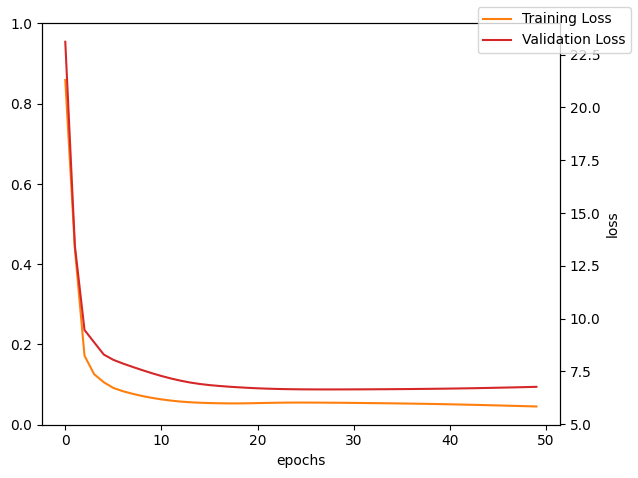

In [365]:
OUTPUT_SIZE = 2 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 50 #  BEST: 50
DROPOUT = 0.0 #  BEST: 0.0
N_LAYERS = 1 # Number of RNN layers  BEST: 1
HIDDEN_DIM = 64 # Dimension of the lstm's hidden state (Embedding)  BEST: 64
LEARNING_RATE = 1e-2 #  BEST: 0.1
WEIGHT_DECAY = 1e-5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_losses, val_losses = [], []

plotter = PlotTraining()
# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = False).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = False).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

## Evaluation

In [366]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0)

testing_mask = torch.all(test_x_pad != 0, dim=-1)
testing_mask = testing_mask[:, ::4]

y_pred = model(test_x_pad.to(device)).reshape(900, 2).cpu().detach().numpy()
y_pred_indexed = y_pred[testing_mask.reshape(900,)]
y_test = test_y_pad.reshape(900, 2).cpu()
y_test_indexed = y_test[testing_mask.reshape(900,)]

In [367]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test, y_pred), 2))

Mean absolute error = 1.36
Mean squared error = 3.56
Median absolute error = 0.99
Explain variance score = 0.76
R2 score = 0.76


# Task **2**

## Data Handling and Preprocessing

In [368]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data_task23")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%202_3/train/trajectory_{i}.npz?raw=true", task='task 2'))
  save_dataset(train_data, "train_data_task23")

In [369]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data_task23")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%202_3/test/trajectory_{i}.npz?raw=true", task='task 2'))
  save_dataset(test_data, "test_data_task23")

In [370]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_batch)

## Model Training

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time:  4.45s | train loss   17.618 validation loss   20.494 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time:  4.28s | train loss    9.463 validation loss   12.046 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time:  4.25s | train loss    2.129 validation loss    4.310 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time:  4.26s | train loss    2.065 validation loss    3.808 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time:  4.37s | train loss    2.006 validation loss    3.512 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time:  4.30s | train loss    1.988 validation loss    3.358 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time:  4.29s | train loss    1.808 validation loss    3.252 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time:  4.34s | train loss    1.898 validation loss    3.229 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time:  4.29s | train loss    1.844 validation loss    3.177 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  10 | time:  4.27s | train loss    1.820 validation loss    3.167 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  11 | time:  4.31s | train loss    1.818 validation loss    3.152 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  12 | time:  4.28s | train loss    1.889 validation loss    3.132 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  13 | time:  4.24s | train loss    1.704 validation loss    3.105 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  14 | time:  4.26s | train loss    1.855 validation loss    3.136 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  15 | time:  4.29s | train loss    1.928 validation loss    3.122 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  16 | time:  4.25s | train loss    1.782 validation loss    3.099 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  17 | time:  4.25s | train loss    1.858 validation loss    3.095 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  18 | time:  4.33s | train loss    1.700 validation loss    3.104 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  19 | time:  4.26s | train loss    1.692 validation loss    3.106 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  20 | time:  4.24s | train loss    1.812 validation loss    3.059 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  21 | time:  4.29s | train loss    1.869 validation loss    3.065 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  22 | time:  4.25s | train loss    1.911 validation loss    3.047 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  23 | time:  4.24s | train loss    1.840 validation loss    3.024 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  24 | time:  4.27s | train loss    1.724 validation loss    3.017 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  25 | time:  4.28s | train loss    1.712 validation loss    3.034 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  26 | time:  4.24s | train loss    1.825 validation loss    3.021 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  27 | time:  4.26s | train loss    1.768 validation loss    3.005 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  28 | time:  4.32s | train loss    1.916 validation loss    3.026 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  29 | time:  4.24s | train loss    1.888 validation loss    2.981 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  30 | time:  4.26s | train loss    1.965 validation loss    3.027 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  31 | time:  4.28s | train loss    1.533 validation loss    3.002 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  32 | time:  4.26s | train loss    1.708 validation loss    2.982 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  33 | time:  4.24s | train loss    1.798 validation loss    3.006 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  34 | time:  4.27s | train loss    1.700 validation loss    2.993 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  35 | time:  4.30s | train loss    1.710 validation loss    2.982 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  36 | time:  4.25s | train loss    1.717 validation loss    2.982 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  37 | time:  4.24s | train loss    1.636 validation loss    2.965 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  38 | time:  4.31s | train loss    1.804 validation loss    2.957 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  39 | time:  4.24s | train loss    1.816 validation loss    2.963 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  40 | time:  4.25s | train loss    1.555 validation loss    2.940 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  41 | time:  4.32s | train loss    1.802 validation loss    2.954 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  42 | time:  4.28s | train loss    1.837 validation loss    2.964 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  43 | time:  4.24s | train loss    1.568 validation loss    2.946 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  44 | time:  4.32s | train loss    1.826 validation loss    2.964 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  45 | time:  4.33s | train loss    1.641 validation loss    2.967 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  46 | time:  4.28s | train loss    1.795 validation loss    2.931 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  47 | time:  4.28s | train loss    1.672 validation loss    2.962 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  48 | time:  4.32s | train loss    1.914 validation loss    2.947 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  49 | time:  4.28s | train loss    1.700 validation loss    2.965 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  50 | time:  4.27s | train loss    1.639 validation loss    2.935 
-----------------------------------------------------------


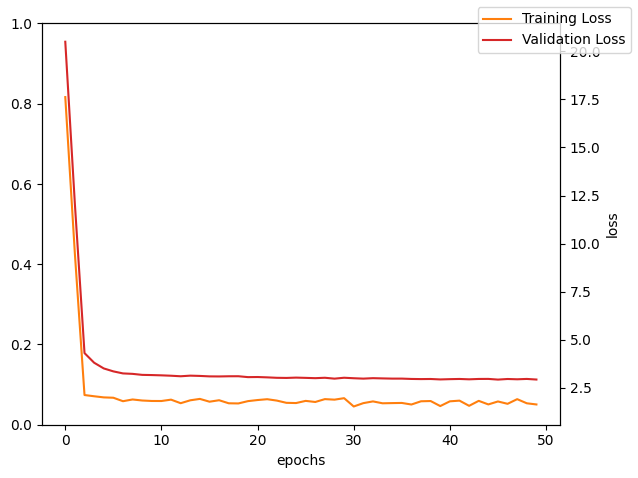

In [394]:
OUTPUT_SIZE = 49*4 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 50 #  BEST: 50, starts overfitting afterwards
DROPOUT = 0.5 #  BEST: 0.5
N_LAYERS = 1 # Number of RNN layers  BEST: 1
HIDDEN_DIM = 512 # Dimension of the lstm's hidden state (Embedding)  BEST: 256
LEARNING_RATE = 0.05 #  BEST: 0.1
WEIGHT_DECAY = 1e-2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_loss, val_loss = [], []

plotter = PlotTraining()

# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = True).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = True).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

## Evaluation

In [395]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0).narrow(dim=-1, start=0, length=2)

testing_mask = torch.all(test_x_pad != 0, dim=-1)
testing_mask = testing_mask[:, ::4]

y_pred = model(test_x_pad.to(device))

y_pred_indexed = y_pred[testing_mask]

reshaped_y_pred = y_pred_indexed.view(y_pred_indexed.shape[0], 49, 4).narrow(dim=-1, start=0, length=2).reshape(y_pred_indexed.shape[0], 98).cpu().detach().numpy()
y_test = test_y_pad.view(test_y_pad.shape[0], test_y_pad.shape[1], 49, 2).reshape(900, 98)

y_test_indexed = y_test[testing_mask.reshape(900,)]

In [396]:
print("Mean absolute error =", round(sm.mean_absolute_error(y_test_indexed, reshaped_y_pred), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test_indexed, reshaped_y_pred), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test_indexed, reshaped_y_pred), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test_indexed, reshaped_y_pred), 2))
print("R2 score =", round(sm.r2_score(y_test_indexed, reshaped_y_pred), 2))

Mean absolute error = 1.12
Mean squared error = 2.61
Median absolute error = 0.87
Explain variance score = 0.88
R2 score = 0.88


<ipython-input-275-f217580a6712>:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_x = true_x[mask]
<ipython-input-275-f217580a6712>:27: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_y = true_y[mask]


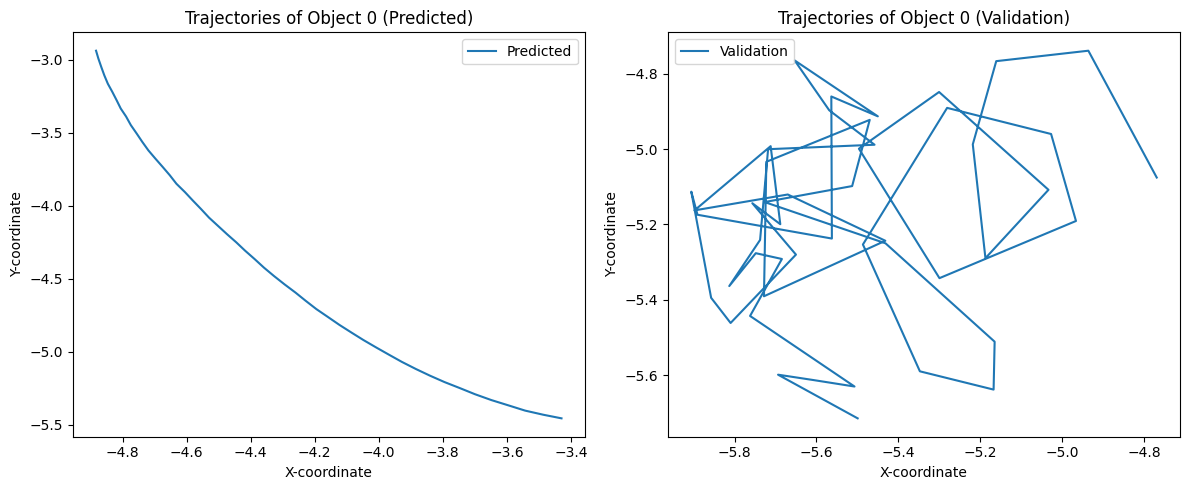

In [400]:
plot_prediction(
    y_pred = y_pred_indexed,
    y_test = y_test_indexed,
    object_index = 0,
    uncertainty = False)

# Task **3**

## Data Handling and Preprocessing

In [401]:
test_x = [torch.tensor(array[0]) for array in test_data]
test_y = [torch.tensor(array[1]) for array in test_data]

test_x_rotations = [sequence_rotation(sequence) for sequence in test_x]

test_x_pad = pad_sequence(test_x_rotations, batch_first=True, padding_value=0)
test_y_pad = pad_sequence(test_y, batch_first=True, padding_value=0).narrow(dim=-1, start=0, length=2)

testing_mask = torch.all(test_x_pad != 0, dim=-1)
testing_mask = testing_mask[:, ::4]

y_pred = model(test_x_pad.to(device))

y_pred_indexed = y_pred[testing_mask]

reshaped_y_pred = y_pred_indexed.view(y_pred_indexed.shape[0], 49, 4).narrow(dim=-1, start=0, length=2).reshape(y_pred_indexed.shape[0], 98).cpu().detach().numpy()
y_test = test_y_pad.view(test_y_pad.shape[0], test_y_pad.shape[1], 49, 2)

y_test_indexed = y_test[testing_mask].reshape(y_test_indexed.shape[0], 98)

In [420]:
for module in model.modules():
    if module.__class__.__name__.startswith('Dropout'):
        module.train()

fwd_passes = 100
predictions = []

for fwd_pass in range(fwd_passes):
    output = model(test_x_pad.to(device))
    reshaped_output = output.view(output.shape[0], output.shape[1], 49, 4).narrow(dim=-1, start=0, length=2).reshape(900, 98)

    np_output = reshaped_output.detach().cpu().numpy()

    predictions.append(np_output)

predictions = np.array(predictions, dtype=np.float64)
indexed_predictions = predictions[:, testing_mask.reshape(900,)]

In [421]:
sampled_predictions, distribution_predicitons = uncertainty_distribution(indexed_predictions)

In [422]:
# Use sampled predictions to test results
print("Mean absolute error =", round(sm.mean_absolute_error(y_test_indexed, sampled_predictions), 2))
print("Mean squared error =", round(sm.mean_squared_error(y_test_indexed, sampled_predictions), 2))
print("Median absolute error =", round(sm.median_absolute_error(y_test_indexed, sampled_predictions), 2))
print("Explain variance score =", round(sm.explained_variance_score(y_test_indexed, sampled_predictions), 2))
print("R2 score =", round(sm.r2_score(y_test_indexed, sampled_predictions), 2))

Mean absolute error = 1.19
Mean squared error = 2.79
Median absolute error = 0.94
Explain variance score = 0.87
R2 score = 0.87


<ipython-input-414-f217580a6712>:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_x = true_x[mask]
<ipython-input-414-f217580a6712>:27: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_y = true_y[mask]


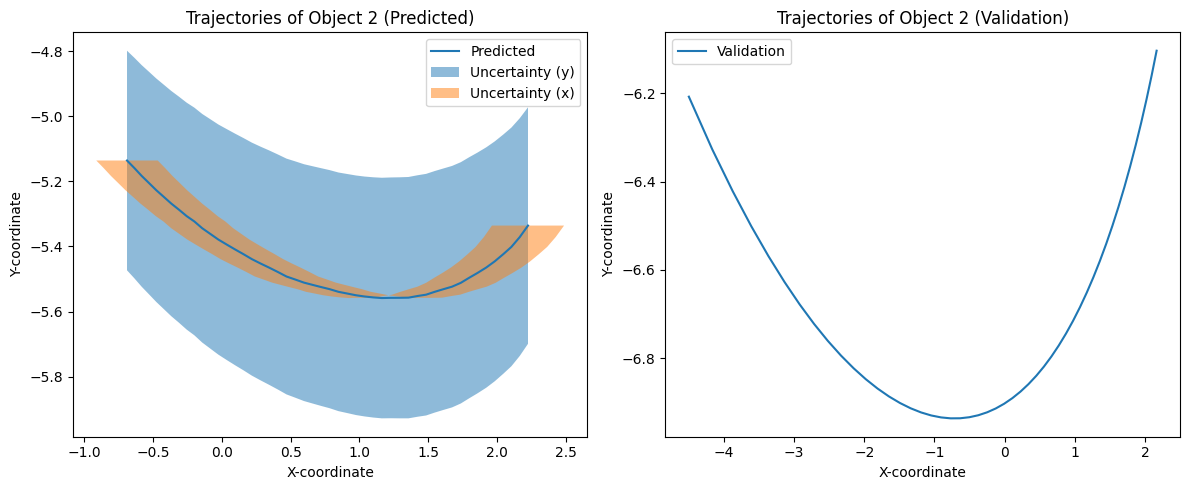

In [423]:
plot_prediction(
    y_pred = distribution_predicitons,
    y_test = y_test_indexed,
    object_index = 2,
    uncertainty = True
    )